In [1]:
import ast
import numpy as np
import torch
import matplotlib.pyplot as plt

from constants import DEVICE
from modules.data_utils import H5LazyDataset, DataUtils, MultiPipeline

In [2]:
h5_lazy_dataset = H5LazyDataset(
    'data/train/train.h5', 'waveforms', 'labels',
    data_transforms=(
        lambda data: torch.tensor(data, dtype=torch.complex64, device=DEVICE),
        torch.fft.fft,
        torch.abs,
        lambda data: data.to(dtype=torch.float64),
        DataUtils.min_max_normalize,
        torch.fft.fftshift,
    ),
    label_transforms=(
        lambda _bytes: _bytes.decode('utf-8'),
        ast.literal_eval,
        lambda label: torch.tensor(label, dtype=torch.float64, device=DEVICE),
        MultiPipeline.split(4),
        MultiPipeline.apply(
            DataUtils.identity,
            DataUtils.sparse_band_centers,
            DataUtils.sparse_band_starts,
            DataUtils.sparse_band_stops,
        ),
    ),
)

In [3]:
waveform: torch.Tensor
label: torch.Tensor
waveform, labels = h5_lazy_dataset[9332]

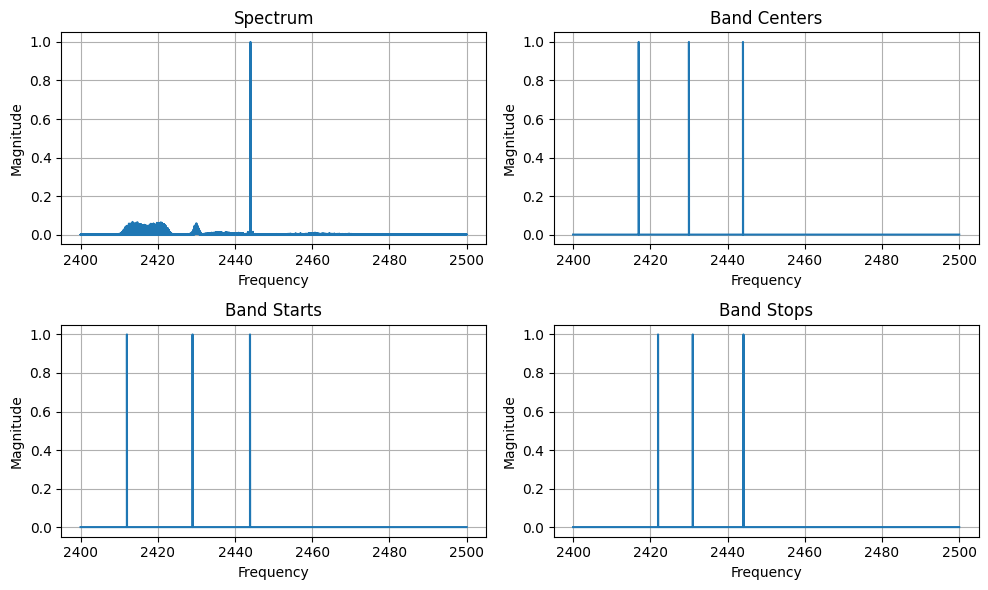

tensor([[2443.8750, 2444.1250],
        [2412.0000, 2422.0000],
        [2429.0000, 2431.0000]], device='cuda:0', dtype=torch.float64)


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for _axes, data, title in zip (np.ravel(axes), (waveform, *labels[1:]), ('Spectrum', 'Band Centers', 'Band Starts', 'Band Stops')):
    DataUtils.plot_spectrum(data, axes=_axes, title=title)

plt.tight_layout()
plt.show()
print(labels[0])